# Music Genre Classification

*mbabusha, rachithp,smuthuku*

There has been a focussed expansion in the digital music services space over the last decade. Popular music services like Spotify and Pandora offer over 30 million songs in their music library. Music genre classification is essential for the Music industry since it acts as a product(for example Shazam) itself or as a base to generate recommendations to their customers.

Our project aims to classify music genres for tracks using structured feature data and audio data. This is an interesting problem to tackle because of the inherently subjective nature of assigning genres to songs. Automatic music genre classification is also challenging because of the retrieval of feature information from audio tracks. Genre classification is a multi class, multi label problem because each song can either belong to a single genre or can be a combination of multiple genres. We wil tackle the multi class problem here.

In [40]:
import pandas as pd
import spotipy
import scipy.sparse as sc
import numpy as np
from sklearn.preprocessing import StandardScaler
from matplotlib import*
import matplotlib.pyplot as plt
from matplotlib.cm import register_cmap
from scipy import stats
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.model_selection import GridSearchCV
import collections
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
from scipy.stats import mode
import math

from sklearn.metrics import confusion_matrix

##  Data setup
We are primarily using Spotify API to scrape data. We first set up an application in Spotify developer API and obtained the `client_id` and `client_secret`. This helps us access the Spotify API. We will be using the python package `Spotipy` which is built exclusively for Spotify (http://spotipy.readthedocs.io/en/latest/).

We will also be using the Million song dataset available at https://labrosa.ee.columbia.edu/millionsong/pages/getting-dataset. The final dataset will be a merged from the scraped data from Spotify API and the million song dataset.


### Setup for web scraping from Spotify

Steps for set up:
Set up your own Spotify user account on www.spotify.com by signing in
Log into the Spotify Developer website using the user account you just created, and go to your Dashboard page
To complete your account set up, you will need to accept the latest Developer Terms of Service
Register your application or project and obtain a `client_id` and a `client_secret`
Now, will need to install the Spotipy package using the following code in your python terminal:

`pip install spotipy`

or

`easy_install spotipy`




## Data Understanding and Preparation

### 1. Tracks and Genre labels:
 
From the `MSD` repository we extracted a subset of songs that had a genre labeled to them. We used the artist names and song title data as a base to scrape from Spotify. The audio_features and search endpoint of Spotify were used to extract the necessary information.

### 2. Timbre features:
Timbre gives the quality of a musical note. It describes the sound that distinguishes different types of musical instruments, or voices. It is derived from the shape of a segment’s spectro-temporal surface, independently of pitch and loudness. This aids significantly in distinguishing different instruments and some instruments are used in particular genres significantly.

To get this data we used the `MSD` repository that had the 12-length-vector of timbre features on different tracks. We used the average and standard deviations of the 12 dimensions as features that would define the structural aspect of each track.



### 3. Audio Features
In order to classify genres, we needed features that would help us distinguish songs that belong to a particular genre. Using the track titles and artist names, we scraped the Spotify web API to get the Audio features for each track. We found that we could get the following audio features for every song:

    	`acousticness`
    	`danceability`
	    `duration_ms`
    	`energy`
    	`instrumentalness`
	    `key`
    	`liveness`
        `loudness`
        `mode`
    	`speechiness`
        `tempo`
    	`time_signature`
    	`valence`

| Feature | Explanation |
| --- | --- | --- |
|Acousticness| range [0,1] - This represents the acoustic quality of the track. A 1.0 value indicates high acoustic confidence.|
|Danceability|range [0,1]- suggests how appropriate a song would be for dancing based on inherent components like tempo,beat strength etc| 
|Duration_ms| This represents the track duration in milliseconds|
|Energy|range [0,1]- This represents the intensity of a particular track. Several perceptual features like dynamic range, perceived loudness, timbre, onset rate, and general entropy contribute to computing energy of the track.|
|Instrumentalness|range [0,1]- is high when track contains no vocals i.e it is more of a an instrumental track with lesser vocal components.|
|Key|The key or pitch class profile the track is in.|
|Liveness|range [0,1] - these help in identifying live tracks by detecting the presence of audiences in the track|
|Loudness| The overall average loudness of a particular track expressed in decibels.|
|Mode| Melodic content from which the track is derived. A track generally belongs to a major or minor scale|
|Speechiness |range [0,1] -this helps in identifying speech components in a track. For example, a rap genre track might have high speechiness value|
|Tempo|The overall estimated tempo of a track in beats per minute (BPM).|
|Time signature| Number of beats in each bar of the track|
|Valence |range [0,1]- this can help in identifying how positive (mood) a soundtrack is. Tracks with high valence sound are considered positive (e.g. happy, cheerful), while tracks with low valence sound are considered negative (e.g. sad, depressed, angry).|

   	 

 


In [4]:
df_train = pd.read_csv('msd_data.csv', encoding='ISO-8859-1')
df_train.head()
subset = df_train[['title','artist_name']]


In [81]:
#Using the spotify api to get feature information for the songs in the MSD data set.
from spotipy.oauth2 import SpotifyClientCredentials
client_credentials_manager = SpotifyClientCredentials(client_id='bd5308ebcdcd467881bd7342f3aaeeda',
                                                      client_secret='20902c7e86a64dc285e0a99be7c499dc')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
track_ids=[]

for index, row in subset.iterrows():

    track= row['title']
    artist=row['artist_name']

    try:
        track_id = sp.search(q='artist:' + artist + ' track:' + track, type='track')
        
        song=track_id['tracks']['items']
        if song:
            track_ids.append([track,artist,song[0]['id']])
        
    except Exception:
            continue

In [17]:
print(len(track_ids))

16288


In [77]:
print(len(track_ids))
df = pd.DataFrame(track_ids, columns=['track','artist','id'])
df.to_csv('track_ids.csv', sep=',')

35466


In [90]:
features_set=[]
ids=df['id'].tolist()
for i in range(0,len(track_ids),50): 
    audio_features= sp.audio_features(ids[i:i+50])
    for track in audio_features:
        if track is not None:
            features_set.append(track)

In [91]:
feat_df=pd.DataFrame(features_set)
feat_df.to_csv('feat_ids.csv', sep=',')

In [33]:
#Merging files for MSD, and the Spotify features
msd = pd.read_csv('msd_data.csv', encoding='ISO-8859-1')
feat = pd.read_csv('feat_ids.csv', encoding='ISO-8859-1')
track = pd.read_csv('track_ids.csv', encoding='ISO-8859-1')
merged=track.join(feat, lsuffix='id', rsuffix='id')
with_msd=merged.join(msd, lsuffix='track', rsuffix='title')
with_msd.to_csv('full.csv', sep=',')

*The Spotify API often times out while processing such a large data set. Hence we had to subset some of the music tracks and re run them. *

In [34]:
list_tracks=with_msd['track'].tolist()

new_set=subset[~subset.title.isin(list_tracks)]
indices=new_set.index
the_left=subset.ix[indices]

In [5]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
client_credentials_manager = SpotifyClientCredentials(client_id='bd5308ebcdcd467881bd7342f3aaeeda',
                                                      client_secret='20902c7e86a64dc285e0a99be7c499dc')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
track_sets=[]
i=0
for index, row in subset.iterrows():
    track= row['title']
    artist=row['artist_name']
    try:
        track_id = sp.search(q='artist:' + artist + ' track:' + track, type='track')
        
        song=track_id['tracks']['items']
        if song:
            i=i+1
            track_sets.append([track,artist,song[0]['id']])
        
    except Exception:
            continue

In [39]:
print(len(track_sets))
rf = pd.DataFrame(track_sets, columns=['track','artist','id'])
rf.to_csv('tracks_left.csv', sep=',')

21361


In [40]:
features_new=[]
idset=rf['id'].tolist()
for i in range(0,len(track_sets),50): 
    audio_features= sp.audio_features(idset[i:i+50])
    for track in audio_features:
        if track is not None:
            features_new.append(track)


### Spotify Api Challenges:

Spotify has extensive feature information - values derived from spectograms, statistical values, audio features etc for millions of songs. Hence, we wanted to primarily use scraped data from Spotify API only. When we explored the Spotify API for data collection process, we found that even though we were able to extract tracks and its respective audio features, we were not able to extract the genre labels for those tracks. Out of 40K tracks we found genre labels for only 200 of them. This made it computationally expensive for us to extract the genre labels using Spotify and hence decided to use the MSD dataset.

In [8]:

df_train = pd.read_csv('full_drop.csv',encoding='ISO-8859-1')

df_train.head()
print("No of tracks extracted:",len(df_train))


df_train.drop('MSD_track_id',axis=1, inplace=True)
print(df_train.columns)

No of tracks extracted: 40572
Index(['track', 'artist', 'genre', 'Spotify ID', 'acousticness',
       'danceability', 'duration_ms', 'energy', 'instrumentalness', 'keytrack',
       'liveness', 'loudnesstrack', 'modetrack', 'speechiness', 'tempotrack',
       'time_signaturetrack', 'valence', 'avg_timbre1', 'avg_timbre2',
       'avg_timbre3', 'avg_timbre4', 'avg_timbre5', 'avg_timbre6',
       'avg_timbre7', 'avg_timbre8', 'avg_timbre9', 'avg_timbre10',
       'avg_timbre11', 'avg_timbre12', 'var_timbre1', 'var_timbre2',
       'var_timbre3', 'var_timbre4', 'var_timbre5', 'var_timbre6',
       'var_timbre7', 'var_timbre8', 'var_timbre9', 'var_timbre10',
       'var_timbre11', 'var_timbre12', 'Unnamed: 42'],
      dtype='object')


### Final dataset
We combined the audio features, timbre features and the respective genre mapping to every song as a single dataset. Based on the number of tracks that we were able to search on the Spotify API, we were able to collect audio data for 6 genres. We have a total of ~30K tracks with audio features and timbre features.

### Dataset Preparation(imbalance in dataset):

The above dataset that we curated had an inherent imbalance. This is prevalent in most of the music genre datasets. To ensure that this imbalance does not skew our prediction models by a large factor, we dropped a few rows from the genre that has the largest number of tracks: `Classic Pop and Rock`. Thus we only retained 10000 rows (shuffled data) for this genre and performed classification on this dataset.



In [9]:
#df_train.genre.unique()

df_rock=df_train[df_train.genre=="classic pop and rock"]
df_rock = df_rock.sample(frac=1).reset_index(drop=True)#shuffle data 
df_rock=df_rock[:10000] #selecting only top 10000 tracks

df_train = df_train[df_train.genre!="classic pop and rock"]

In [11]:
df_train=pd.concat([df_rock, df_train], ignore_index=True)
len(df_train)# final dataset

36677

The initial process subsets only the features that are necessary for classifying the genre of the track.Here we observe that we use only the spotify features/audio tags and timbral features extracted from MSD.

`features_xdf` contains all the features that is used for classification of genre.
We also standardize the data for classification algorithms that uses distance as the similarity measure

In [46]:
#Subsetting only the required audio features
features_x=df_train.loc[:, 'acousticness':'var_timbre12']
#standardizing the features so that the scales remain consistent
mean = features_x.mean(axis=0)
std = features_x.std(axis=0)
X_std = (features_x - mean) / std

print(features_x.head())

   acousticness  danceability  duration_ms  energy  instrumentalness  \
0        0.3860         0.370       189733   0.806          0.000000   
1        0.3640         0.656       198867   0.326          0.000000   
2        0.1700         0.541       323467   0.860          0.000478   
3        0.6850         0.764       148547   0.615          0.000000   
4        0.0986         0.531       218907   0.667          0.000006   

   keytrack  liveness  loudnesstrack  modetrack  speechiness      ...       \
0        10    0.0832         -6.294          1       0.0421      ...        
1         0    0.2460         -9.630          1       0.0521      ...        
2        10    0.0635         -5.191          1       0.0371      ...        
3         1    0.2500         -5.850          1       0.0344      ...        
4         0    0.0915         -9.721          0       0.0590      ...        

   var_timbre3  var_timbre4  var_timbre5  var_timbre6  var_timbre7  \
0   810.057337   590.095570 

**features_y contains the output/labels variable that contains the genre information**

In [13]:
features_y=df_train.loc[:,'genre']#label/target variable contains only the genre
print(features_y.head())

0    classic pop and rock
1    classic pop and rock
2    classic pop and rock
3    classic pop and rock
4    classic pop and rock
Name: genre, dtype: object


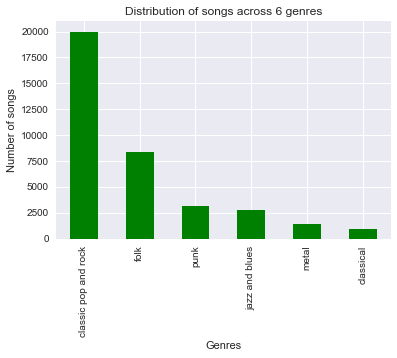

In [79]:


plt.figure(2)
features_y.value_counts().plot(kind='bar', color='green')
plt.title('Distribution of songs across 6 genres')
plt.xlabel('Genres')
plt.ylabel('Number of songs')
plt.show()

This graph suggests that there is still an existing imbalance in this data set. This is because a higher number of songs are produced for a particular genre in comparison to others. Previously, the number of `classic pop and rock` outnumbered the other genres by a huge factor. To reduce this huge difference we subsetted a smaller portion of the `classic pop and rock` songs. Apart from that, we are still using the data with the inherent imbalance because most of the music datasets have this kind of a distribution.

Label Encoder ensures that it gives numerical values to each of the genres so that it can be used as an input to various classifiers.

In [16]:
features_x.isnull().values.any()#check for null and nan values
#np.where(np.asanyarray(np.isnan(features_x)))[0]# checking for nan

False

In [17]:
from sklearn import preprocessing
#Label encoder can convert string variables into numerical categorical features
le = preprocessing.LabelEncoder()
Y=le.fit_transform(features_y)

In [47]:
from sklearn.model_selection import train_test_split
# splitting data into train and test data(75% and 25% split)
X_train, X_test,Y_train, Y_test = train_test_split(features_x,features_y, test_size=0.25, random_state=42)
X_train_std, X_test_std,Y_train_std, Y_test_std = train_test_split(X_std,Y, test_size=0.25, random_state=42)

## KNN

Our first attempt to create a genre classification model began with a K- Nearest Neighbors Classifier. We used KNN in cohort with a grid search to get the K hyper parameter value. Using this model, gave us an accuracy rate of 76.11%. 


In [78]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
#Grid search KNN 
parameters = {'n_neighbors':[1, 10]}
neigh = KNeighborsClassifier()
grid_neigh = GridSearchCV(neigh, parameters)
grid_neigh.fit(X_train_std, Y_train_std) 
Y_pred=grid_neigh.predict(X_test_std)
accuracy=grid_neigh.score(X_test_std,Y_test_std)
print(accuracy)

0.811886586696


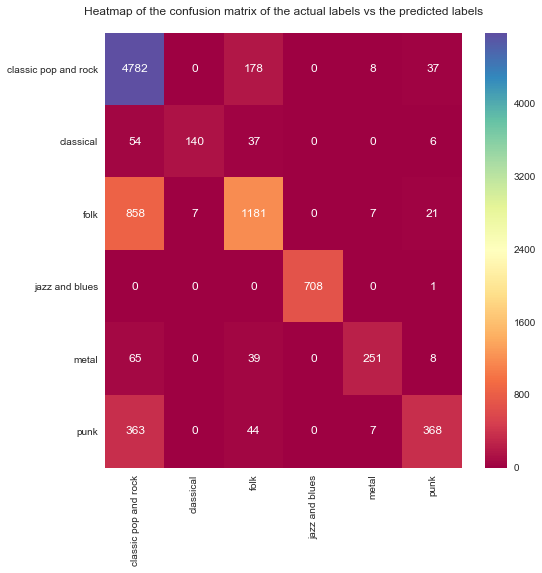

In [73]:
#confusion matrix
plt.figure(num=None, figsize=(8, 8))
cm = confusion_matrix((Y_test_std),le.transform(Y_pred), labels=[0,1,2,3,4,5])
df_cm = pd.DataFrame(cm, index=list(le.inverse_transform([0,1,2,3,4,5])), columns=list(le.inverse_transform([0,1,2,3,4,5])))
ax = sns.heatmap(df_cm,annot = True, cmap="Spectral", fmt="d")
ax.set_title('Heatmap of the confusion matrix of the actual labels vs the predicted labels\n')
plt.yticks(rotation=0) 

plt.show()

## Random Forest (Custom)
A Random Forest classifier was also used as one of the models to understand the accuracy of the model to predict genres.

Random forest works on both bagging and boosting concepts. Bagging selects training samples at random with replacement and boosting selects a subset of features every iteration to build a decision tree.

In our model, we consider 20% of features being selected for every iteration of building a tree. Also, this implementation of random forests is built on 100 decision trees.


In [19]:
from random import choices
l=[]
# to randomly select training samples from data(bagging)
for i in range(0,len(X_train)):
    l.append(i)
t=(choices(l, k=len(X_train)))

In [20]:
n_samples=int(len(X_train.columns.values)*0.20) #find number of features to sample for every tree (Boosting)

In [21]:
import random
from sklearn.tree import DecisionTreeClassifier
list_choice =[]
train_columns=[]
ypred_train=[]
ypred_test=[]
#building 100 decision trees to create a random forest
for i in range(0,100):
    list_choice.append(choices(l, k=len(X_train)))
    train_columns.append(random.sample(set(X_train.columns.values), n_samples))
    #bagging and boosting steps
    R_train = X_train[X_train.columns.intersection(train_columns[i])]
    R_train = R_train.iloc[list_choice[i],]
   
    R_Y_train = Y_train.iloc[list_choice[i],]
    R_test = X_test[X_test.columns.intersection(train_columns[i])]
    # fitting a decision tree based on features and samples selected for the current iteration
    DT=DecisionTreeClassifier(random_state=0)
    DT.fit(R_train,R_Y_train)
    ypred_train.append(DT.predict(R_train))
    ypred_test.append(DT.predict(R_test))
    
    

In [22]:
import numpy as np
for i in range(len(ypred_test)):
    ypred_test[i] =le.transform( ypred_test[i].ravel())# convert back to numerical values

for i in range(len(ypred_train)):
    ypred_train[i] =le.transform( ypred_train[i].ravel())# convert back to numerical values  


In [23]:

y_p_train =np.vstack(ypred_train)

y_p_test =np.vstack(ypred_test)


In [24]:
# using mode as the statistics value to find the dominant genre 
y_pred_train= mode(y_p_train)
y_pred_train=(y_pred_train[0].tolist()[0])
y_pred_test= mode(y_p_test)
y_pred_test=(y_pred_test[0].tolist()[0])

In [25]:
test_error = (len(Y_test)-len([i for i, j in zip(y_pred_test, le.transform(Y_test.tolist())) if i == j]))/len(Y_test)
print("Test Error:",round(test_error*100,3),"%")
print("Test Accuracy:", round((1-test_error)*100,3),"%")

Test Error: 23.719 %
Test Accuracy: 76.281 %


### Random Forest Confusion Matrix

From the confusion matrix, we observe that ‘Jazz and Blues’ have been perfectly classified.
The reason why ‘Jazz and Blues’ was classified perfectly could have been because of the fact that it is different in its feature configurations from the other genres . 

The other genres have a huge overlap with ‘classic pop and rock’. Especially ‘Folk’ and ‘Punk’ have been the two most genres that were misclassified as ‘classic pop and rock’. This is probably because of the overlap in structure, audio features and timbral features of these two genres. Another reason could be that ‘classic pop and rock’ have the highest number of songs in this dataset. Therefore, this imbalance could have led most of the songs to be classified as 
‘classic pop and rock’.



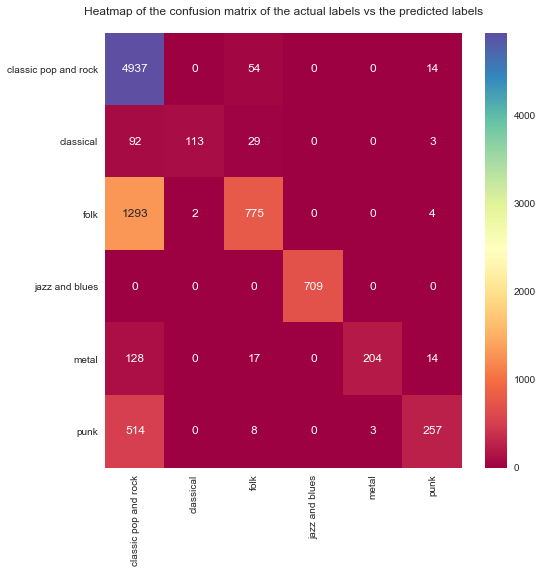

In [26]:
plt.figure(num=None, figsize=(8, 8))
cm = confusion_matrix(le.transform(Y_test.tolist()),y_pred_test, labels=[0,1,2,3,4,5])
df_cm = pd.DataFrame(cm, index=list(le.inverse_transform([0,1,2,3,4,5])), columns=list(le.inverse_transform([0,1,2,3,4,5])))
ax = sns.heatmap(df_cm,annot = True, cmap="Spectral", fmt="d")
ax.set_title('Heatmap of the confusion matrix of the actual labels vs the predicted labels\n')
plt.yticks(rotation=0) 

plt.show()

## Random Forest (sklearn)
To check the performance of the custom random forest, we ran a scikit learn Random Forest model. Our implementation of the Random Forest gives us an accuracy of 76% and the sklearn Random Forest Classifier gives us an accuracy of 81%. Thus we can observe that our implementation has led to almost good accuracy rates as the sklearn package implementation.






In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
parameters = {'max_depth':[5, 25]}
clf_rf = RandomForestClassifier(random_state=0)
clf = GridSearchCV(clf_rf, parameters)
clf.fit(X_train, Y_train)
Y_pred=clf.predict(X_test)
accuracy=clf.score(X_test,Y_test)
print("Accuracy after grid search for selected features:",accuracy)


Accuracy after grid search for selected features: 0.810250817884


### Feature Importances

The Random forest implementation of the sklearn package gives us the importance of every feature. Feature importance is decided by the distance that a test point must travel before a decision is made. Lesser the depth, more the feature importance. Hence, this helps us to decide which feature split helps in best distinguishing the genres. 




In [36]:
#extracting importance of features 
temp=[]
for i in range(len(features_x.columns)):  
    temp.append((features_x.columns[i],clf.feature_importances_[i]))
    
df = pd.DataFrame(temp,columns=['Feature Names','Importance'])
print(df)

          Feature Names  Importance
0          acousticness    0.047358
1          danceability    0.018278
2           duration_ms    0.025209
3                energy    0.028224
4      instrumentalness    0.044775
5              keytrack    0.008273
6              liveness    0.014974
7         loudnesstrack    0.026278
8             modetrack    0.002536
9           speechiness    0.020282
10           tempotrack    0.015506
11  time_signaturetrack    0.003053
12              valence    0.031949
13          avg_timbre1    0.095469
14          avg_timbre2    0.052063
15          avg_timbre3    0.022040
16          avg_timbre4    0.031406
17          avg_timbre5    0.030488
18          avg_timbre6    0.024406
19          avg_timbre7    0.021630
20          avg_timbre8    0.020562
21          avg_timbre9    0.019091
22         avg_timbre10    0.025504
23         avg_timbre11    0.017970
24         avg_timbre12    0.022149
25          var_timbre1    0.043077
26          var_timbre2    0

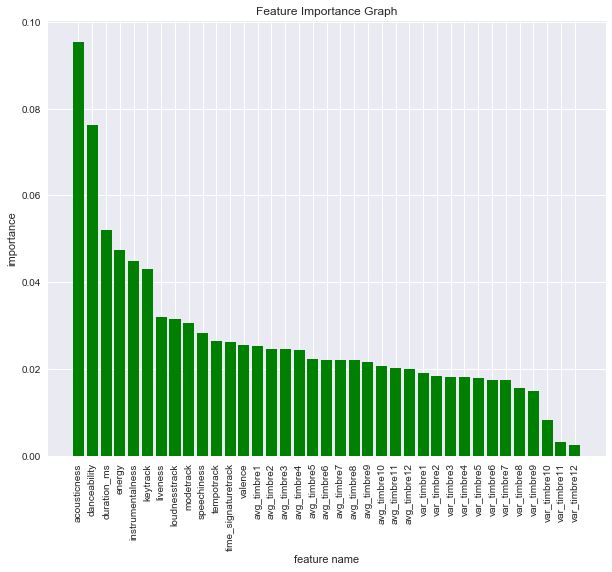

In [37]:
importance_f = clf.feature_importances_
indices = np.argsort(importance_f)[::-1]

plt.figure(figsize=(10,8))
plt.bar(range(X_train.shape[1]), importance_f[indices],
    color="g", 
    align="center")
feature_names = features_x.columns 
plt.xticks(range(X_train.shape[1]), feature_names,rotation=90)
plt.title("Feature Importance Graph")
plt.ylabel("importance")
plt.xlabel("feature name")
plt.show()

## Stochastic Gradient Descent 
Since a standard SVM model will not be able to perform a multi-class classification on our data without a kernel. We decided to use the Stochastic Gradient Descent with a `hinge loss` to model the data like how we would using an SVM classifier with a kernel. We used the SKLearn Stochastic Gradient Descent and obtained a 74% accuracy on the test data. The confusion matrix as expected was not able to classify the `folk` and `punk` genres too well.


In [48]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss="hinge", penalty="l2",alpha=0.001, max_iter=100)
clf.fit(X_train_std, Y_train_std) 
Y_pred=clf.predict(X_test_std)

In [49]:
accuracy=clf.score(X_test_std,Y_test_std)
print(accuracy)

0.742202835333


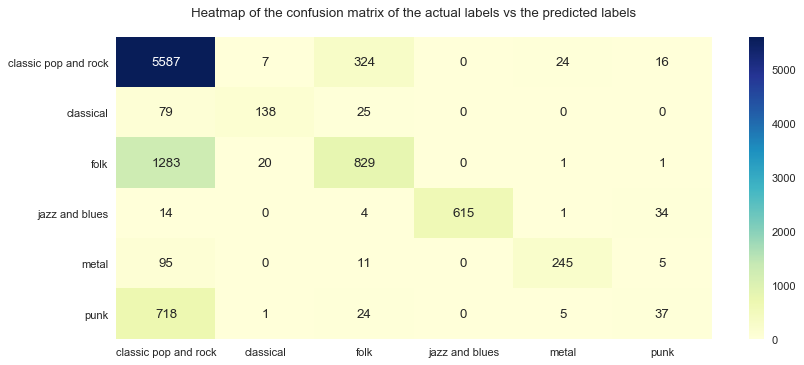

In [37]:
plt.figure(num=None, figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
cm = confusion_matrix(Y_test_std,Y_pred, labels=[0,1,2,3,4,5])
df_cm = pd.DataFrame(cm, index=list(le.inverse_transform([0,1,2,3,4,5])), columns=list(le.inverse_transform([0,1,2,3,4,5])))
ax = sns.heatmap(df_cm,annot = True, cmap="YlGnBu", fmt="d")
ax.set_title('Heatmap of the confusion matrix of the actual labels vs the predicted labels\n')
plt.show()

### Model Comparison
We have used accuracy as our metric to observe model performance. After running the above models, we get:

| Classifier | Accuracy Rates |
| --- | --- | --- |
|KNN|81.2 %|  
|Random Forest (custom)| 76.281 %|
|Random Forest (sklearn)|81.02 %|
|stochastic gradient descent |74.2% |


### Conclusion:

The table above shows the accuracy rates that we obtained from each of the models that were used for classification of music genre. We observe that KNN and Random Forest gives us the best accuracies. Random Forest inherently features selects and builds a classifier based on several decision trees thus improving prediction accuracy. 

Independent decisions are made across each decision tree in the random forest which helps bring down possible variance in the model.Given that this is a multi-class multi-label problem, we observe that Random Forest is able to distinguish between possibly overlapping genres and make predictions for the tracks with reasonable accuracy. Therefore, the random forest is a good estimator in the genre classification process. 

KNN is nonparametric and hence does not have assumptions about the underlying distribution. KNN is modelled on a distance metric. This is particularly useful in this case, as we have used numerical data features. The distance metric groups together points that are dimensionally closer into the same class. Thus, this gives us a good prediction basis.  

#### Next Steps
Further steps from here on would involve adding in more genres to the classification set and attempting to find a model that can deal with the inherent genre features overlap. We would also attempt to tackle the multi label problem as an extension. 

### Resources

There are several organisations that have great music libraries with an assortment of features. They could be a good place to start understanding how music data helped. Our resources:

4M. Defferrardy, K. Benziy, P. Vandergheynsty, X. Bressonz, FMA: A DATASET FOR
MUSIC ANALYSIS, EPFL, Switzerland zSCSE, NTU, Singapore

H. Michael, H.Yang, K.Kenny Music Genre Classification -
CS229 - cs229.stanford.edu @article chen_gao_zhu_

